In [6]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torchaudio
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler
from transformers import AutoModel
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# --- CONFIGURATION ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SFM_CSV = "sfm_features.csv" 
BATCH_SIZE = 8
NUM_CLASSES = 6 # Update this if you have a different number of classes

# --- 1. DEFINE DATASETS ---
class VoicePathologyDataset(Dataset):
    def __init__(self, df, sfm_scaler, sfm_cols):
        self.df = df.reset_index(drop=True)
        self.sfm_scaler = sfm_scaler
        self.sfm_cols = sfm_cols
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        file_path = row['file_path']
        raw_sfm = row[self.sfm_cols].values.astype(np.float32)
        norm_sfm = self.sfm_scaler.transform([raw_sfm])[0]
        sfm_tensor = torch.tensor(norm_sfm, dtype=torch.float32)
        label = torch.tensor(row['label_encoded'], dtype=torch.long)
        return file_path, sfm_tensor, label

def custom_collate(batch):
    paths = [item[0] for item in batch] 
    sfms = torch.stack([item[1] for item in batch])
    labels = torch.stack([item[2] for item in batch])
    return paths, sfms, labels

class CNNDataset(Dataset):
    def __init__(self, df):
        self.df = df.reset_index(drop=True)
        self.mel_transform = torchaudio.transforms.MelSpectrogram(
            sample_rate=16000, n_fft=1024, win_length=1024, hop_length=160, n_mels=128
        )
        self.db_transform = torchaudio.transforms.AmplitudeToDB()
        self.resize = T.Resize((128, 128))
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        try: waveform, sr = torchaudio.load(row['file_path'])
        except: waveform = torch.zeros(1, 16000*3); sr=16000
        if sr != 16000: waveform = torchaudio.transforms.Resample(sr, 16000)(waveform)
        img = self.resize(self.db_transform(self.mel_transform(waveform)))
        img = (img - img.mean()) / (img.std() + 1e-6)
        label = torch.tensor(row['label_encoded'], dtype=torch.long)
        return img, label

# --- 2. DEFINE MODELS ---
class DualStreamModel(nn.Module):
    def __init__(self, num_classes, sfm_dim=10, fusion_dim=512):
        super().__init__()
        self.audio_encoder = AutoModel.from_pretrained("hance-ai/audiomae", trust_remote_code=True)
        self.audio_proj = nn.Linear(768, fusion_dim)
        self.sfm_mlp = nn.Sequential(
            nn.Linear(sfm_dim, 64), nn.BatchNorm1d(64), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(64, fusion_dim), nn.LayerNorm(fusion_dim)
        )
        self.cross_attn = nn.MultiheadAttention(embed_dim=fusion_dim, num_heads=8, batch_first=True)
        self.classifier = nn.Sequential(nn.Linear(fusion_dim, 256), nn.ReLU(), nn.Dropout(0.4), nn.Linear(256, num_classes))

    def forward(self, audio_paths, sfm_input):
        audio_feats = torch.stack([self.audio_encoder(p) for p in audio_paths]).to(self.audio_proj.weight.device)
        batch_size = audio_feats.shape[0]
        audio_feats = audio_feats.view(batch_size, 768, -1).permute(0, 2, 1)
        audio_emb = self.audio_proj(audio_feats) 
        sfm_emb = self.sfm_mlp(sfm_input) 
        attn_out, _ = self.cross_attn(query=sfm_emb.unsqueeze(1), key=audio_emb, value=audio_emb)
        return self.classifier(attn_out.squeeze(1)), None

class BasicCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        
        # Block 1
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2) 
        )
        
        # Block 2
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2) 
        )
        
        # Block 3
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2) 
        )
        
        # Classifier
        # Crucial Fix: self.flatten is separate, NOT inside nn.Sequential
        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(128 * 16 * 16, 256), # This is now Index 0 (Matches your saved file)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.flatten(x) # Flatten happens here
        logits = self.fc(x)
        return logits

# --- 3. PREPARE DATA ---
full_df = pd.read_csv(SFM_CSV)
label_encoder = LabelEncoder()
full_df['label_encoded'] = label_encoder.fit_transform(full_df['label_name'])
NUM_CLASSES = len(label_encoder.classes_)
sfm_cols = ['jitter_local', 'jitter_rap', 'shimmer_local', 'shimmer_apq3', 'hnr', 'f1', 'f2', 'f3', 'f4', 'f0_mean']
scaler = StandardScaler()
scaler.fit(full_df[full_df['split'] == 'train'][sfm_cols].values)
test_df = full_df[full_df['split'] == 'test'].reset_index(drop=True)
if len(test_df) == 0: test_df = full_df[full_df['split'] == 'val'].reset_index(drop=True)

print("✅ Setup Complete! All classes and data loaded.")

✅ Setup Complete! All classes and data loaded.


🚀 Starting Model Ensemble (Dual-Stream + CNN)...


c:\Users\sreeh\miniconda3\envs\your_env_name\lib\site-packages\huggingface_hub\file_download.py:949: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


🤖 Extracting Dual-Stream Predictions...
👀 Extracting CNN Predictions...


c:\Users\sreeh\miniconda3\envs\your_env_name\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



🏆 ENSEMBLE Accuracy: 89.74%

📝 Ensemble Classification Report:
                        precision    recall  f1-score   support

      Cysts_Structural       0.63      0.55      0.59        22
             Dysarthia       1.00      1.00      1.00        42
            Laryngitis       0.67      0.76      0.71        42
           Vox senilis       0.86      0.89      0.87        93
             parkinson       0.98      0.99      0.99       200
spasmodische_dysphonie       0.82      0.45      0.58        20

              accuracy                           0.90       419
             macro avg       0.83      0.77      0.79       419
          weighted avg       0.90      0.90      0.89       419



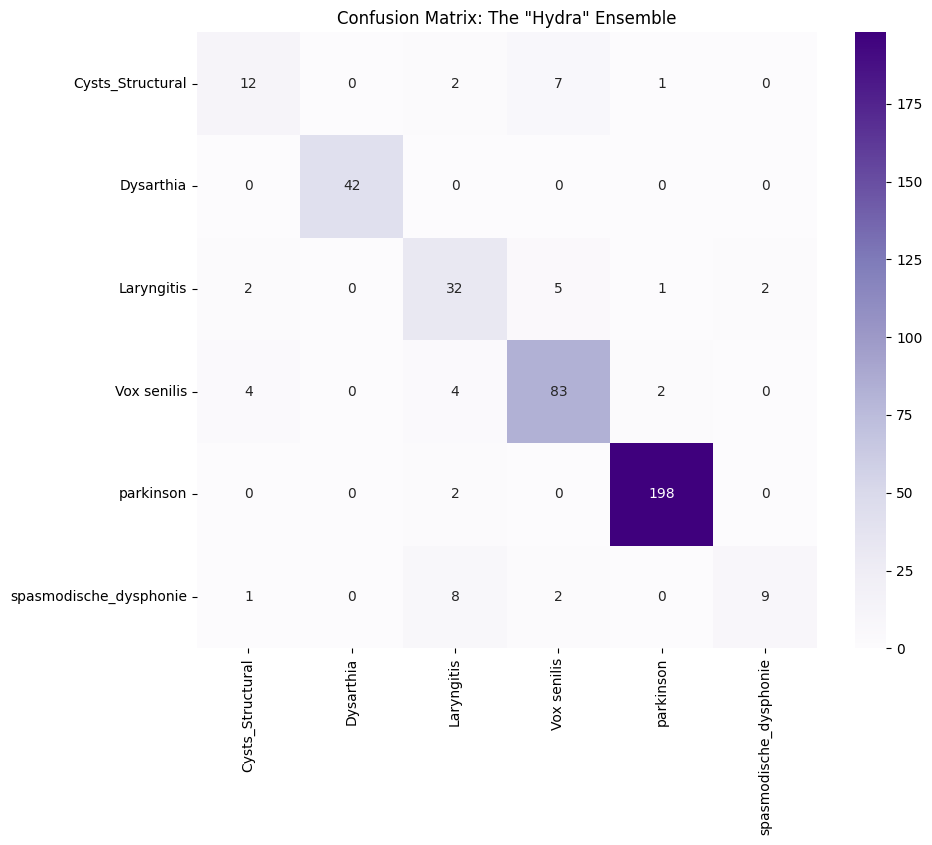

In [7]:
import torch.nn.functional as F

print("🚀 Starting Model Ensemble (Dual-Stream + CNN)...")

# --- 1. SETUP LOADERS (Ensure identical order) ---
# We reuse the specific datasets we created earlier to ensure inputs are correct
# Dual-Stream Loader
test_ds_dual = VoicePathologyDataset(test_df, scaler, sfm_cols)
loader_dual = DataLoader(test_ds_dual, batch_size=BATCH_SIZE, shuffle=False, collate_fn=custom_collate)

# CNN Loader
test_ds_cnn = CNNDataset(test_df)
loader_cnn = DataLoader(test_ds_cnn, batch_size=BATCH_SIZE, shuffle=False)

# --- 2. LOAD MODELS ---
# Load Dual-Stream (Best Weighted/Focal Version)
model_dual = DualStreamModel(num_classes=NUM_CLASSES).to(DEVICE)
model_dual.load_state_dict(torch.load(r"DualStream\Models\WeightedDualStream\best_weighted_model.pth")) # Or best_weighted_model.pth
model_dual.eval()

# Load CNN (Best Baseline)
model_cnn = BasicCNN(num_classes=NUM_CLASSES).to(DEVICE)
model_cnn.load_state_dict(torch.load("baseline_basic_cnn.pth"))
model_cnn.eval()

# --- 3. GET PREDICTIONS ---
probs_dual = []
probs_cnn = []
true_labels = []

print("🤖 Extracting Dual-Stream Predictions...")
with torch.no_grad():
    for paths, sfms, labels in loader_dual:
        sfms = sfms.to(DEVICE)
        logits, _ = model_dual(paths, sfms)
        # Convert Logits -> Probabilities (0.0 to 1.0)
        probs = F.softmax(logits, dim=1)
        probs_dual.append(probs.cpu().numpy())
        true_labels.append(labels.numpy())

print("👀 Extracting CNN Predictions...")
with torch.no_grad():
    for imgs, _ in loader_cnn: # Ignore labels here, we already have them
        imgs = imgs.to(DEVICE)
        logits = model_cnn(imgs)
        probs = F.softmax(logits, dim=1)
        probs_cnn.append(probs.cpu().numpy())

# Concatenate all batches
import numpy as np
probs_dual = np.concatenate(probs_dual)
probs_cnn = np.concatenate(probs_cnn)
true_labels = np.concatenate(true_labels)

# --- 4. THE BOOST (ENSEMBLE) ---
# We can just average them (50/50 split)
# OR give more weight to the better model (e.g., 0.6 * Dual + 0.4 * CNN)
# Let's try a straight 50/50 average first
final_probs = (probs_dual + probs_cnn) / 2
final_preds = np.argmax(final_probs, axis=1)

# --- 5. RESULTS ---
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

acc = accuracy_score(true_labels, final_preds)
print(f"\n🏆 ENSEMBLE Accuracy: {acc*100:.2f}%")

print("\n📝 Ensemble Classification Report:")
print(classification_report(true_labels, final_preds, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(true_labels, final_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix: The "Hydra" Ensemble')
plt.show()